# vLife Virtusa
## Predicting the Wait Time of Hospitals
### Usecase Description
The model predicts the wait time for a hospital by taking into account various parameters lie hospital Rating, Hospital Ownership etc by using Regression modelling


### Dataset Source
Data for this usecase can be found [here](https://www.kaggle.com/cms/hospital-general-information).

### Dataset Description
<p> This file contains general information about all hospitals that have been registered with Medicare, including their addresses, type of hospital, and ownership structure. It also contains information about the quality of each hospital, in the form of an overall rating (1-5, where 5 is the best possible rating & 1 is the worst), and whether the hospital scored above, same as, or below the national average for a variety of measures. </p>.

#### Import Section

In [27]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, 
import seaborn as sns #for plotting 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV

In [28]:
df = pd.read_csv("HospInfo.csv")
df.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote,Location
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,Same as the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Below the national average,NaN,"2505 U S HIGHWAY 431 NORTH\nBOAZ, AL\n"
1,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,...,NaN,Same as the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Same as the national average,NaN,"200 MED CENTER DRIVE\nFORT PAYNE, AL\n"
2,10032,WEDOWEE HOSPITAL,209 NORTH MAIN STREET,WEDOWEE,AL,36278,RANDOLPH,2563572111,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,Not Available,Results are not available for this reporting p...,Same as the national average,NaN,Same as the national average,NaN,Not Available,Results are not available for this reporting p...,"209 NORTH MAIN STREET\nWEDOWEE, AL\n"
3,10095,HALE COUNTY HOSPITAL,508 GREEN STREET,GREENSBORO,AL,36744,HALE,3346243024,Acute Care Hospitals,Government - Local,...,Results are not available for this reporting p...,Not Available,Results are not available for this reporting p...,Below the national average,NaN,Same as the national average,NaN,Not Available,Results are not available for this reporting p...,"508 GREEN STREET\nGREENSBORO, AL\n"
4,10131,CRESTWOOD MEDICAL CENTER,ONE HOSPITAL DR SE,HUNTSVILLE,AL,35801,MADISON,2568823100,Acute Care Hospitals,Proprietary,...,NaN,Same as the national average,NaN,Same as the national average,NaN,Same as the national average,NaN,Same as the national average,NaN,"ONE HOSPITAL DR SE\nHUNTSVILLE, AL\n"


## Exploratory Data Analysis

**Observations**
Several things that stood out that are wortth checking/cleaning:
* 1: Overall, the dataset is quite clean. Each hospital seems to be uniquely identifed by the ProviderID. It would be a good idea to double check if that's the case
* 2: Right away, we see there are potential missing values, labeled 'Not Available', that should be considered NA. However, they are technically not read as such. This creates a problem when we want to pass in these values into a predictive model because it would consider these 'Not Available' as real data and not missing values that should be ignored. (Ex. Take a look at Hale County Hospital's hospital rating)
* 3: Further note on the categorical data, each variable is written in two variables - one that contains the actual descriptive data and the other that contains additional explanation if the original value was not given or 'Not Available'' in this sense. It seems that the only explanation (so far) for a value that does not have any available data will state "Results are not available for this reporting...". For now, I would toss out any variables that have the words "footnote" to make our dataset smaller and easier to read because containing these variables results in redundancy. 

*For exploratory data analysis* There weren't any numerical variables (you can't add phone numbers together). There are PLENTY of categorical, specifically ordinal, variables that are present in the latter half of the dataset. We could make same bar charts to see if there is any association with timeliness of care.

>**Observation I** Check if first observation is true - is Provider ID truly an unique identifier? The output below confirms this assumption, so it is safe to use this identifier moving forward. (we could also use hospital name as an identifier, but it may be possible that some hospitals have the same names)

In [29]:
nrows = df.shape[0]
num_unique_hosp = df['Provider ID'].nunique()
print("Is Provider ID a unique identifier?: {0}".format(nrows == num_unique_hosp))

Is Provider ID a unique identifier?: True


> **Observation #2**  Incorporate NAs. Note that NaN is now written as Hale County Hospital's rating. (NaN is equivalent to NA in R)

>**Observation #3** Remove redundant columns for ease of reading.

In [30]:
#Replace text with NaN that can be read as true missing value in Python
df = df.replace('Not Available', np.nan )

#Drop all columns whose name contains 'footnote'
cols_to_drop = list(df.filter(regex='footnote'))
df_clean = df[df.columns.drop(cols_to_drop)]

#print to see results
df_clean.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Meets criteria for meaningful use of EHRs,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison,Location
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,True,3,Below the national average,Same as the national average,Above the national average,Same as the national average,Same as the national average,Above the national average,Below the national average,"2505 U S HIGHWAY 431 NORTH\nBOAZ, AL\n"
1,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,...,True,3,Below the national average,Same as the national average,Same as the national average,Same as the national average,Same as the national average,Above the national average,Same as the national average,"200 MED CENTER DRIVE\nFORT PAYNE, AL\n"
2,10032,WEDOWEE HOSPITAL,209 NORTH MAIN STREET,WEDOWEE,AL,36278,RANDOLPH,2563572111,Acute Care Hospitals,Government - Hospital District or Authority,...,True,4,Same as the national average,NaN,Same as the national average,NaN,Same as the national average,Same as the national average,NaN,"209 NORTH MAIN STREET\nWEDOWEE, AL\n"
3,10095,HALE COUNTY HOSPITAL,508 GREEN STREET,GREENSBORO,AL,36744,HALE,3346243024,Acute Care Hospitals,Government - Local,...,True,NaN,NaN,NaN,NaN,NaN,Below the national average,Same as the national average,NaN,"508 GREEN STREET\nGREENSBORO, AL\n"
4,10131,CRESTWOOD MEDICAL CENTER,ONE HOSPITAL DR SE,HUNTSVILLE,AL,35801,MADISON,2568823100,Acute Care Hospitals,Proprietary,...,True,3,Below the national average,Above the national average,Same as the national average,Same as the national average,Same as the national average,Same as the national average,Same as the national average,"ONE HOSPITAL DR SE\nHUNTSVILLE, AL\n"


In [41]:
row1 = df_clean.iloc[:1,:]

In [42]:
row1.values

array([[10005, True, True, 3.0, 'Below the national average',
        'Same as the national average', 'Above the national average',
        'Same as the national average', 'Same as the national average',
        'Above the national average', 'Below the national average', 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

_Let's tackle the hospitals with long waiting times. Approximately, how many of these hospitals are in the dataset?_

In [33]:
#normalize = True gives the percentages of each value instead of frequencies
df_clean['Timeliness of care national comparison'].value_counts(normalize=True)


Same as the national average    0.438240
Above the national average      0.306825
Below the national average      0.254935
Name: Timeliness of care national comparison, dtype: float64

_From the output, we see a little over a quarter of hospitals have below national average. This may be a small representation, but keep in mind that this is a quarter of ALL hospitals in the US in the CMS system. How many does this mean? Let's find out._

In [34]:
print("Out of {0} total hospitals, how many have below average wait times?\
 {1} hospitals".format(nrows, round(nrows * 0.255)))

Out of 4812 total hospitals, how many have below average wait times? 1227 hospitals


Roughly 1200+ hospitals have longer wait times than the national average. This is a problem since longer waiting times are correlated with patient dissatisifaction. Having patients wait longer could also induce more stress and anxiety (https://www.bmj.com/content/342/bmj.d2983) 

Let's explore other variables in the dataset to see which features are most correlated with these hospitals. In the end, we could use unsupervised learning and predictive models to confirm these attributes. Once we have discovered these features, we could make recomendations for these hospitals to allocate their resources more effectively that will, hopefully, improving timeliness of care. 

### Data Preprocessing
Now, before we go into modeling, we should do clean our data by dealing with:
* missing values in both our data and target variable ('Timeliness of care national comparison')
* text data that must be converted into a format the XGBoost can read, which are categorical variables

*Missing Values*
From the output below, we see that two variables have a little less than half of their values missing: Safety of care (~45%) and efficient use of medical imaging (~42%). Since they're less than half, their values can still be useful for modeling, so I'll keep them here. XGboost is also known to be robust against having missing values. 

In [36]:
#Calculate percentage of missing data in each column
df_clean.isnull().mean().sort_values(ascending=False)

Safety of care national comparison                      0.450540
Efficient use of medical imaging national comparison    0.422485
Patient experience national comparison                  0.284497
Mortality national comparison                           0.280964
Timeliness of care national comparison                  0.263092
Hospital overall rating                                 0.258728
Effectiveness of care national comparison               0.249792
Readmission national comparison                         0.211347
Meets criteria for meaningful use of EHRs               0.029925
County Name                                             0.003117
Location                                                0.000000
State                                                   0.000000
Hospital Name                                           0.000000
Address                                                 0.000000
City                                                    0.000000
Emergency Services       

_There were missing values in our target variable: 'Timeliness of care national comparison' so let's remove all rows that contain those_

_From this process, we've dropped approximately 26% of the rows. We haven't lost much information, so this is good news_


In [37]:
#store the number of rows before (b) dropping
num_rows_b = df_clean.shape[0]

df_clean = df_clean.loc[df_clean["Timeliness of care national comparison"].notnull(), :]
 
#check if there is no missnig data in target variable
print("% of missing data in target variable after cleaning: {:.0%}"\
      .format(df_clean["Timeliness of care national comparison"].isnull().mean()))

#store the number of rows after (a) dropping
num_rows_a = df_clean.shape[0]

#Show the change in number of rows
print("# of rows before dropping NAs: {0}\n# of rows after dropping NAs: {1}"\
      .format(num_rows_b, num_rows_a))

% of missing data in target variable after cleaning: 0%
# of rows before dropping NAs: 4812
# of rows after dropping NAs: 3546


_Dropping more unnecessary variables in order to be more efficient and to not confuse the model._

In [38]:
#Remove Hospital Name, Address, City, State, Zip Code, County Name, Phone Number, and Location 
#Keep Provider ID for key later on so that we could pull in other information if we want to.
df_clean = df_clean.drop([
    "Hospital Name", "Address", "City", 
    "State", "ZIP Code", "Phone Number",
    "County Name", "Location"
], axis =1)

#See if values that are categorical are truly categorical, bools as truly bool and int as ints
df_clean.dtypes

Provider ID                                              int64
Hospital Type                                           object
Hospital Ownership                                      object
Emergency Services                                        bool
Meets criteria for meaningful use of EHRs               object
Hospital overall rating                                 object
Mortality national comparison                           object
Safety of care national comparison                      object
Readmission national comparison                         object
Patient experience national comparison                  object
Effectiveness of care national comparison               object
Timeliness of care national comparison                  object
Efficient use of medical imaging national comparison    object
dtype: object

In [39]:
#Categorical variables are correctly casted as object type
#Emergency Services is bool but Meets criteria for meaningful use of EHR is not. Let's convert this to bool
df_clean['Meets criteria for meaningful use of EHRs'] = \
df_clean['Meets criteria for meaningful use of EHRs'].astype(bool)

#hospital overall rating should be numerical type (int doesn't accept missing values, so conver to float type)
df_clean['Hospital overall rating'] = df_clean['Hospital overall rating'].astype(float)

df_clean.dtypes

Provider ID                                               int64
Hospital Type                                            object
Hospital Ownership                                       object
Emergency Services                                         bool
Meets criteria for meaningful use of EHRs                  bool
Hospital overall rating                                 float64
Mortality national comparison                            object
Safety of care national comparison                       object
Readmission national comparison                          object
Patient experience national comparison                   object
Effectiveness of care national comparison                object
Timeliness of care national comparison                   object
Efficient use of medical imaging national comparison     object
dtype: object

### Creation of Categorical and Dummy Variables

Since all of our data has text data, let's convert these values to ordinal values (categorical values with an order to them. For example, "low", "medium" and "high"  can be represented numerically by 1, 2, 3. where "high" (3)  is greater than "low" (1).)

In summary, these variables will be converted into the following format as follows:
* Dummy Variables for nominal data: Hospital Type and Hospital Ownership
* Categorical variables(factorization) for ordinal data: Emergency Services, Meets criteria for meaningful use of EHRs, the remaining variables with "national comparison" 
* Categorical variables for boolean data: Emergency Services and Meets criteria for meaningful use of EHRs

*Note: Hospital overall rating is already in factorized form, so we can leave this alone and convert back to integers later on*. 

In [40]:
#Create dummy variables for Hospital Type and Hospital Ownership and save into dv 
dv = pd.get_dummies(df_clean[['Hospital Type', 'Hospital Ownership']] )
dv.head()

#drop old columns and concatenate new dummy variables
df_clean = df_clean.drop(['Hospital Type', 'Hospital Ownership'], axis=1)
df_clean = pd.concat([df_clean, dv], axis=1)

#print head to check results (they're appended to the end)
df_clean.head()
#Remember that Hospital Type and Hospital Ownership did NOT have missing data from the original data.

,Provider ID,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,...,Hospital Ownership_Government - Federal,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private
0,10005,True,True,3.0,Below the national average,Same as the national average,Above the national average,Same as the national average,Same as the national average,Above the national average,...,0,1,0,0,0,0,0,0,0,0
1,10012,True,True,3.0,Below the national average,Same as the national average,Same as the national average,Same as the national average,Same as the national average,Above the national average,...,0,0,0,0,0,1,0,0,0,0
2,10032,True,True,4.0,Same as the national average,NaN,Same as the national average,NaN,Same as the national average,Same as the national average,...,0,1,0,0,0,0,0,0,0,0
3,10095,True,True,NaN,NaN,NaN,NaN,NaN,Below the national average,Same as the national average,...,0,0,1,0,0,0,0,0,0,0
4,10131,True,True,3.0,Below the national average,Above the national average,Same as the national average,Same as the national average,Same as the national average,Same as the national average,...,0,0,0,0,0,1,0,0,0,0


In [43]:
row1 = df_clean.iloc[:1,:]

In [46]:
row1

,Provider ID,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,...,Hospital Ownership_Government - Federal,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private
0,10005,True,True,3.0,Below the national average,Same as the national average,Above the national average,Same as the national average,Same as the national average,Above the national average,...,0,1,0,0,0,0,0,0,0,0


In [45]:
row1.values

array([[10005, True, True, 3.0, 'Below the national average',
        'Same as the national average', 'Above the national average',
        'Same as the national average', 'Same as the national average',
        'Above the national average', 'Below the national average', 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

In [50]:
row1.dtypes

Provider ID                                                         int64
Emergency Services                                                   bool
Meets criteria for meaningful use of EHRs                            bool
Hospital overall rating                                           float64
Mortality national comparison                                      object
Safety of care national comparison                                 object
Readmission national comparison                                    object
Patient experience national comparison                             object
Effectiveness of care national comparison                          object
Timeliness of care national comparison                             object
Efficient use of medical imaging national comparison               object
Hospital Type_Acute Care Hospitals                                  uint8
Hospital Type_Critical Access Hospitals                             uint8
Hospital Ownership_Government - Federa

In [14]:
#create list of columns to convert to ordinal
    # only modify variables that have "national compmarison" in naming
ordinal_col = list(df_clean.filter(regex="national comparison"))

#Create customized mapper to factorize variables that are ordinal nature
mapper = {
    'Below the national average' : 0,
    'Same as the national average' : 1, 
    'Above the national average' : 2
}
for col in ordinal_col:
    df_clean.loc[:, df_clean.columns == col]= df_clean.loc[:, df_clean.columns == col].replace(mapper)

#print results. 
df_clean.head() 

,Provider ID,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,...,Hospital Ownership_Government - Federal,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private
0,10005,True,True,3.0,0.0,1.0,2.0,1.0,1.0,2,...,0,1,0,0,0,0,0,0,0,0
1,10012,True,True,3.0,0.0,1.0,1.0,1.0,1.0,2,...,0,0,0,0,0,1,0,0,0,0
2,10032,True,True,4.0,1.0,NaN,1.0,NaN,1.0,1,...,0,1,0,0,0,0,0,0,0,0
3,10095,True,True,NaN,NaN,NaN,NaN,NaN,0.0,1,...,0,0,1,0,0,0,0,0,0,0
4,10131,True,True,3.0,0.0,2.0,1.0,1.0,1.0,1,...,0,0,0,0,0,1,0,0,0,0


In [15]:
#Factorize Emergency and Meets criteria for meaningful use of EHRs into booleans
    #true = 1 and False = 0
bool_cols = ['Emergency Services', 'Meets criteria for meaningful use of EHRs']

df_clean[bool_cols] = (df_clean[bool_cols] == True).astype(int)

#print head to see results
df_clean.head()

,Provider ID,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,...,Hospital Ownership_Government - Federal,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private
0,10005,1,1,3.0,0.0,1.0,2.0,1.0,1.0,2,...,0,1,0,0,0,0,0,0,0,0
1,10012,1,1,3.0,0.0,1.0,1.0,1.0,1.0,2,...,0,0,0,0,0,1,0,0,0,0
2,10032,1,1,4.0,1.0,NaN,1.0,NaN,1.0,1,...,0,1,0,0,0,0,0,0,0,0
3,10095,1,1,NaN,NaN,NaN,NaN,NaN,0.0,1,...,0,0,1,0,0,0,0,0,0,0
4,10131,1,1,3.0,0.0,2.0,1.0,1.0,1.0,1,...,0,0,0,0,0,1,0,0,0,0


In [16]:
df_clean=df_clean.fillna(df_clean.mean())

In [17]:
df_clean.drop(columns=['Provider ID'], inplace = True)

In [18]:
df_clean.columns

Index(['Emergency Services', 'Meets criteria for meaningful use of EHRs',
       'Hospital overall rating', 'Mortality national comparison',
       'Safety of care national comparison', 'Readmission national comparison',
       'Patient experience national comparison',
       'Effectiveness of care national comparison',
       'Timeliness of care national comparison',
       'Efficient use of medical imaging national comparison',
       'Hospital Type_Acute Care Hospitals',
       'Hospital Type_Critical Access Hospitals',
       'Hospital Ownership_Government - Federal',
       'Hospital Ownership_Government - Hospital District or Authority',
       'Hospital Ownership_Government - Local',
       'Hospital Ownership_Government - State', 'Hospital Ownership_Physician',
       'Hospital Ownership_Proprietary', 'Hospital Ownership_Tribal',
       'Hospital Ownership_Voluntary non-profit - Church',
       'Hospital Ownership_Voluntary non-profit - Other',
       'Hospital Ownership_Volunt

## Predictive Models
### XGB Classifier

_Now, let's try to predict which hospitals have below average wait times using supervised learning (I don't really have much hope for this since the features don't provide enough information...but let's give it a go!). So, our target variable is the "Timeliness of care national comparison". For personal preference, I will experiment with XGBoost as it is a widely popular supervised learning model. We have more samples than features, so using this method is appropriate for this scenario. As with any supervised learning, we need our data matrix, X, and vector of target values, y_

_Our y will be the "Timeliness of care national comparison_

_Moving on, let's split the data into train/test splits where we will train the model using the training data and evaluate the performance of our model on the testing data (It's importnt to note that we will not touch this until the very last step of testing. This is crucial to understanding how well the model will perform on unseen data. It would make no sense to train on both training and testing data, AND THEN predict on the testing data...it would yield 100% accuracy since we're predicting on what we already know.)_

In [19]:
y = df_clean.pop("Timeliness of care national comparison")
X = df_clean

#randomly split into training and testing data. Let's aside 20% of our data for testing.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Compare dimensions:
#Remember that after we dropped rows from earlier, there were 3,546 rows
print("Original X: {0}, Original y: {1}".format(X.shape, y.shape))
print("X Train: {0}, y train: {1}".format(X_train.shape, y_train.shape))
print("X Train: {0}, y test: {1}".format(X_test.shape, y_test.shape))

Original X: (3546, 21), Original y: (3546,)
X Train: (2836, 21), y train: (2836,)
X Train: (710, 21), y test: (710,)


In [20]:
X.columns

Index(['Emergency Services', 'Meets criteria for meaningful use of EHRs',
       'Hospital overall rating', 'Mortality national comparison',
       'Safety of care national comparison', 'Readmission national comparison',
       'Patient experience national comparison',
       'Effectiveness of care national comparison',
       'Efficient use of medical imaging national comparison',
       'Hospital Type_Acute Care Hospitals',
       'Hospital Type_Critical Access Hospitals',
       'Hospital Ownership_Government - Federal',
       'Hospital Ownership_Government - Hospital District or Authority',
       'Hospital Ownership_Government - Local',
       'Hospital Ownership_Government - State', 'Hospital Ownership_Physician',
       'Hospital Ownership_Proprietary', 'Hospital Ownership_Tribal',
       'Hospital Ownership_Voluntary non-profit - Church',
       'Hospital Ownership_Voluntary non-profit - Other',
       'Hospital Ownership_Voluntary non-profit - Private'],
      dtype='object')

In [21]:
X.dtypes

Emergency Services                                                  int64
Meets criteria for meaningful use of EHRs                           int64
Hospital overall rating                                           float64
Mortality national comparison                                     float64
Safety of care national comparison                                float64
Readmission national comparison                                   float64
Patient experience national comparison                            float64
Effectiveness of care national comparison                         float64
Efficient use of medical imaging national comparison              float64
Hospital Type_Acute Care Hospitals                                  uint8
Hospital Type_Critical Access Hospitals                             uint8
Hospital Ownership_Government - Federal                             uint8
Hospital Ownership_Government - Hospital District or Authority      uint8
Hospital Ownership_Government - Local 

In [22]:
#Instantiate XGB classifier model
xgb = XGBClassifier(seed = 123)

# fit model no training data
xgb.fit(X_train, y_train)

#Predict the lables of the test test
preds = xgb.predict(X_test)

# Compute the accuracy: accuracy

accuracy = float(np.sum(preds == y_test)) / y_test.shape[0]
print("accuracy: {:.2f}%".format(accuracy * 100))

accuracy: 53.94%


In [23]:
import pickle
with open('xgb_model.pickle', 'wb') as handle:
    pickle.dump(xgb, handle)

In [47]:
with open('xgb_model.pickle', 'rb') as handle:
    tempp = pickle.load(handle)

In [48]:
preds

array([1, 2, 1, 0, 0, 1, 1, 1, 1, 0, 2, 0, 1, 0, 0, 1, 1, 1, 1, 2, 2, 2,
       1, 1, 0, 2, 0, 1, 1, 1, 1, 0, 1, 2, 0, 2, 2, 1, 0, 2, 2, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 2, 1, 2, 1, 1, 0, 0,
       2, 1, 1, 0, 1, 2, 2, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 2, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 2, 2, 1, 2, 0, 1, 0, 2, 1, 1, 1, 0,
       2, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 0, 0, 1, 1, 0, 2, 1, 1,
       2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 0, 0, 1, 2, 1, 0,
       1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 0, 0, 1, 0, 1, 2, 2, 1, 0, 1, 0,
       2, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 2, 0, 2, 0, 2, 1, 2, 2, 1, 0, 1, 2, 1, 0, 0, 1, 1, 0, 2, 1, 0,
       0, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,

### Feature Importance using XGB

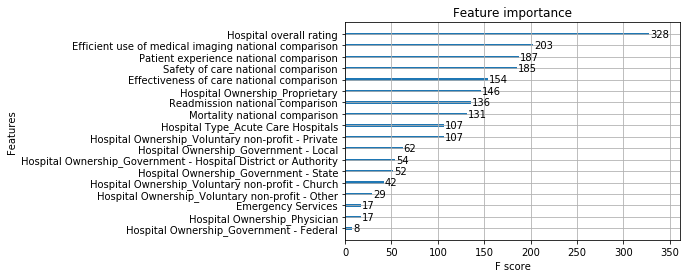

In [49]:
#plot feature importance graph to see which features contribute to predicting the outcomes
plot_importance(tempp)
plt.show()

In [ ]:
#subset features there are "fairly importnat" relate to other features
subset = [
    "Hospital overall rating", "Safety of care national comparison",
    "Efficient use of medical imaging national comparison", 
    "Patient experience national comparison", "Mortality national comparison", 
    "Effectiveness of care national comparison", "Readmission national comparison",
    "Hospital Ownership_Proprietary"
]
X_train = X_train[subset]
X_test = X_test[subset]

xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)

accuracy = float(np.sum(preds == y_test)) / y_test.shape[0]
print("accuracy: {:.2f}%".format(accuracy * 100))

_With an accuracy of ~52%, is it only slightly better than random chance. Let's tune a few of the important hyperparameters to see if we can increase our accuracy. We'll use RandomSearchCV to pick the optimal configuration. In a nutshell, it randomly picks a value for each hyperparameter from the ranges given, then performs k crossfold validation using these parameters. It then averages the testing scores. Whichever set of hyperparameters gives the best 'scoring' is the "best" model. (You can check out GridSearch if you like, but I prefer to save some time here)_ 
 
_However, it is best to not simply train only on the entire training set. From learning theory, a validation accuracy rate is a much more robust measure of testing accuracy rather than training accuracy~_

### Hyper Param Tuning using Random Search

In [ ]:
# Create the parameter grid: gbm_param_grid 
xgb_param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': np.arange(100, 400, 10),
    'max_depth': np.arange(2, 11)
}

# Perform random search with scoring metric negative MSE. 
#Perform 5 fold CV (this is arbitrary)
randomized_mse = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_grid, 
                                    scoring = "accuracy",n_iter=10, cv=5, verbose=1)


# Fit randomized_mse to the data
randomized_mse.fit(X_train, y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

#Predict the lables of the test test
preds = randomized_mse.predict(X_test)

# Compute the accuracy: accuracy

accuracy = float(np.sum(preds == y_test)) / y_test.shape[0]
print("accuracy: {:.2f}%".format(accuracy * 100))

**Conclusive Analysis**

That is it! Predictions are considerably bad...This could be because most of the variables provided don't distinguish slow hospitals from the fast ones, so the model cannot truly learn from the data (since there weren't much patterns to learn from!). More variables would definitely help to improve its predicting power.

As a side note, you can tell from the feature importance graph that the most important features that helped predict hospital's quality of timely care matches what we've seen in our exploratory data analysis process.

If I were to explore this dataset further, I would answer these questions:
1. Which city should you live in that has better hospitals? By better, I mean 
 * Lower readmissions 
 * Shorter waiting periods
 * Lower mortality rates
2. Given a certain disease, which hospital is best for a patient based on shorter waiting period time better mortality rates, and proximity to hospital based on patient's location.
3. I assume that cities have the best hospitals because cites tend to attract better talent. Is this true?
4. If assumption 2 isn't correct, then what types of cities do the best hospitals occur in? Large, mid-sized, or small? Do they differ by geographical regions? (west ocast, east coast, mid-west)

## END